# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**




In [1]:
import os, time, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.amp import GradScaler, autocast
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet, conv3x3

## **Configurazione + Device**

In [2]:
@dataclass
class Config:
    # paths
    data_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset"
    #data_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test"

    # training
    batch_size: int = 64
    epochs: int = 50
    lr: float = 3e-4
    weight_decay: float = 3e-4
    num_workers: int = 4

    # early stopping
    patience: int = 3
    min_delta: float = 1e-3
    monitor: str = "val_loss"  # "val_loss" or "val_f1"
    best_path: str = "best_model.pth"

    # loss / regularization
    label_smoothing: float = 0.1

    # mixup
    mixup_alpha: float = 0.2
    mixup_prob: float = 0.5

    # model
    se_reduction: int = 16


def get_device() -> torch.device:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device


def sanity_check_paths(cfg: Config):
    if not os.path.exists(cfg.data_dir):
        raise FileNotFoundError(f"Train/Val root not found: {cfg.data_dir}")
    print(f"Dataset root: {cfg.data_dir}")
    print(f"Folders found: {os.listdir(cfg.data_dir)}")

    if not os.path.exists(cfg.test_dir):
        print(f"WARNING: Test dir not found: {cfg.test_dir}")
    else:
        print(f"Test dir: {cfg.test_dir}")

## **Preprocessing + Data Augmentation**

In [3]:
class GrayWorldWB:
    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.asarray(img).astype(np.float32)
        mean = arr.mean(axis=(0, 1), keepdims=True)
        arr = arr / (mean + 1e-6)
        arr = arr / (arr.max() + 1e-6)
        return Image.fromarray((arr * 255).astype(np.uint8))


class AutoContrast:
    def __call__(self, img: Image.Image) -> Image.Image:
        return ImageOps.autocontrast(img, cutoff=1)


def build_transforms() -> Dict[str, transforms.Compose]:
    preprocess = transforms.Compose([
        GrayWorldWB(),
        AutoContrast(),
    ])

    train_tf = transforms.Compose([
        preprocess,
        transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.15),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.2),
        transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    ])

    val_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    return {"train": train_tf, "val": val_tf}


def build_test_transforms() -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

## **Dataset + DataLoader**

In [4]:
def build_datasets(cfg: Config, tfs: Dict[str, transforms.Compose]):
    train_ds = datasets.ImageFolder(os.path.join(cfg.data_dir, "train"), tfs["train"])
    val_ds   = datasets.ImageFolder(os.path.join(cfg.data_dir, "valid"), tfs["val"])

    class_names = train_ds.classes
    num_classes = len(class_names)

    print(f"Number of classes: {num_classes}")
    print(f"Training samples: {len(train_ds)}")
    print(f"Validation samples: {len(val_ds)}")

    return {"train": train_ds, "val": val_ds}, class_names, num_classes


def build_dataloaders(cfg: Config, device: torch.device, dsets):
    pin_memory = (device.type == "cuda")
    persistent = (cfg.num_workers > 0)

    dl_kwargs = dict(
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent,
    )
    if persistent:
        dl_kwargs["prefetch_factor"] = 2

    dls = {
        "train": DataLoader(dsets["train"], shuffle=True,  **dl_kwargs),
        "val":   DataLoader(dsets["val"],   shuffle=False, **dl_kwargs),
    }
    sizes = {"train": len(dsets["train"]), "val": len(dsets["val"])}
    return dls, sizes


## **Modello SE-Resnet18 senza pesi**

In [5]:
class SEBlock(nn.Module):
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(1, channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, hidden, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, channels, kernel_size=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.pool(x)
        w = self.fc(w)
        return x * w


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[type[nn.Module]] = None,
        reduction: int = 16,
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("SEBasicBlock supports only groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("SEBasicBlock does not support dilation > 1")

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)

        self.se = SEBlock(planes, reduction=reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


def build_se_resnet18(num_classes: int, device: torch.device, se_reduction: int = 16) -> nn.Module:
    class _SEBasicBlock(SEBasicBlock):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs, reduction=se_reduction)

    model = ResNet(block=_SEBasicBlock, layers=[2, 2, 2, 2], num_classes=1000)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


def build_amp_scaler(device: torch.device) -> GradScaler:
    return GradScaler(enabled=(device.type == "cuda"))

## **Mixup Utils**

In [6]:
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    return x_mix, y, y[idx], lam


def one_hot(labels, num_classes, device):
    return F.one_hot(labels, num_classes=num_classes).float().to(device)


def soft_cross_entropy(logits, soft_targets):
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1).mean()

## **Training (early stop + metriche)**

In [7]:
def train_model(
    model: nn.Module,
    dataloaders: Dict[str, DataLoader],
    dataset_sizes: Dict[str, int],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler,
    device: torch.device,
    cfg: Config,
    scaler: Optional[GradScaler],
    num_classes: int
) -> Tuple[nn.Module, Dict[str, List[float]]]:

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1

    if cfg.monitor not in ("val_loss", "val_f1"):
        raise ValueError("monitor must be 'val_loss' or 'val_f1'")

    if cfg.monitor == "val_loss":
        best_metric = float("inf")
        mode = "min"
    else:
        best_metric = -float("inf")
        mode = "max"

    epochs_no_improve = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
    }

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch}/{cfg.epochs - 1}")
        print("-" * 10)

        epoch_stats = {}

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            seen = 0

            all_preds = []
            all_targets = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):

                    # MixUp SOLO in train
                    use_mixup = (phase == "train" and np.random.rand() < cfg.mixup_prob)
                    if use_mixup:
                        inputs_mix, y_a, y_b, lam = mixup_data(inputs, labels, alpha=cfg.mixup_alpha)
                        soft_targets = lam * one_hot(y_a, num_classes, device) + (1 - lam) * one_hot(y_b, num_classes, device)

                        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                            outputs = model(inputs_mix)
                            loss = soft_cross_entropy(outputs, soft_targets)

                        _, preds = torch.max(outputs, 1)

                        # accuracy pesata (logging)
                        correct_a = (preds == y_a).float().sum().item()
                        correct_b = (preds == y_b).float().sum().item()
                        batch_corrects = lam * correct_a + (1 - lam) * correct_b

                        hard_targets_for_f1 = y_a  # indicativo
                    else:
                        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        batch_corrects = (preds == labels).float().sum().item()
                        hard_targets_for_f1 = labels

                    if phase == "train":
                        if scaler is not None and device.type == "cuda":
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            loss.backward()
                            optimizer.step()

                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += batch_corrects
                seen += bs

                all_preds.append(preds.detach().cpu().numpy())
                all_targets.append(hard_targets_for_f1.detach().cpu().numpy())

            if phase == "train" and scheduler is not None:
                scheduler.step()

            denom = max(1, seen)
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects / denom

            all_preds = np.concatenate(all_preds) if all_preds else np.array([], dtype=np.int64)
            all_targets = np.concatenate(all_targets) if all_targets else np.array([], dtype=np.int64)
            epoch_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0) if all_targets.size else 0.0

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1(macro): {epoch_f1:.4f}")

            epoch_stats[f"{phase}_loss"] = epoch_loss
            epoch_stats[f"{phase}_acc"] = epoch_acc
            epoch_stats[f"{phase}_f1"] = epoch_f1

        # history
        for k in history.keys():
            history[k].append(epoch_stats[k])

        # early stopping
        current = epoch_stats[cfg.monitor]

        improved = (best_metric - current) > cfg.min_delta if mode == "min" else (current - best_metric) > cfg.min_delta

        if improved:
            best_metric = current
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), cfg.best_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= cfg.patience:
            print(f"Early stopping at epoch {epoch} (best {cfg.monitor} at epoch {best_epoch}: {best_metric:.6f})")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed/60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best {cfg.monitor}: {best_metric:.6f} at epoch {best_epoch}")

    model.load_state_dict(best_model_wts)
    return model, history

## **Plot delle curve**

In [8]:
def plot_history(history: Dict[str, List[float]]):
    epochs_range = range(len(history["train_loss"]))
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["train_acc"], label="Train Acc")
    plt.plot(epochs_range, history["val_acc"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["train_f1"], label="Train Macro-F1")
    plt.plot(epochs_range, history["val_f1"], label="Val Macro-F1")
    plt.title("Macro-F1")
    plt.xlabel("Epoch"); plt.ylabel("Macro-F1")
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

## **Evaluation su test + Matrice di confusione**

In [9]:
def build_test_loader(cfg: Config, device: torch.device):
    if not os.path.exists(cfg.test_dir):
        raise FileNotFoundError(f"Test directory not found at {cfg.test_dir}")

    test_tf = build_test_transforms()
    test_ds = datasets.ImageFolder(cfg.test_dir, transform=test_tf)

    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=(device.type == "cuda"),
    )

    print(f"Test samples found: {len(test_ds)}")
    print(f"Classes found: {len(test_ds.classes)}")
    return test_ds, test_loader


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float, np.ndarray, np.ndarray]:
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    for inputs, labels in loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
    return acc, f1, all_targets, all_preds


def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix (normalized)"):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 100):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")

## **Main**

In [11]:
cfg = Config()
device = get_device()
sanity_check_paths(cfg)

Using device: cuda
Dataset root: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset
Folders found: ['test_degradato', 'sports_labels.csv', 'valid', 'test', 'train']
Test dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test


In [14]:
tfs = build_transforms()           
dsets, class_names, num_classes = build_datasets(cfg, tfs)
dls, sizes = build_dataloaders(cfg, device, dsets)

Number of classes: 100
Training samples: 13533
Validation samples: 500


In [15]:
model = build_se_resnet18(
    num_classes=num_classes,
    device=device,
    se_reduction=cfg.se_reduction
)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

optimizer = optim.AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=cfg.epochs
)

scaler = build_amp_scaler(device)

print(model.fc)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Linear(in_features=512, out_features=100, bias=True)
Trainable params: 11316892


In [16]:
model, history = train_model(
    model=model,
    dataloaders=dls,
    dataset_sizes=sizes,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    cfg=cfg,
    scaler=scaler,
    num_classes=num_classes
)

Epoch 0/49
----------
train Loss: 4.1511 Acc: 0.0710 F1(macro): 0.0491
val Loss: 3.7132 Acc: 0.1340 F1(macro): 0.1063
Epoch 1/49
----------
train Loss: 3.6536 Acc: 0.1519 F1(macro): 0.0962
val Loss: 3.3932 Acc: 0.2060 F1(macro): 0.1672
Epoch 2/49
----------
train Loss: 3.4136 Acc: 0.2148 F1(macro): 0.1577
val Loss: 3.0796 Acc: 0.3100 F1(macro): 0.2590
Epoch 3/49
----------
train Loss: 3.1889 Acc: 0.2655 F1(macro): 0.1938
val Loss: 2.7766 Acc: 0.3780 F1(macro): 0.3358
Epoch 4/49
----------
train Loss: 2.9620 Acc: 0.3118 F1(macro): 0.2275
val Loss: 2.6398 Acc: 0.3880 F1(macro): 0.3426
Epoch 5/49
----------
train Loss: 2.7916 Acc: 0.3641 F1(macro): 0.2908
val Loss: 2.4394 Acc: 0.4700 F1(macro): 0.4452
Epoch 6/49
----------
train Loss: 2.6203 Acc: 0.4067 F1(macro): 0.3157
val Loss: 2.2025 Acc: 0.5780 F1(macro): 0.5477
Epoch 7/49
----------
train Loss: 2.4926 Acc: 0.4325 F1(macro): 0.3352
val Loss: 2.2321 Acc: 0.5560 F1(macro): 0.5363
Epoch 8/49
----------
train Loss: 2.4902 Acc: 0.4541 F1(

In [17]:
model = build_se_resnet18(
    num_classes=num_classes,
    device=device,
    se_reduction=cfg.se_reduction
)

model.load_state_dict(torch.load(cfg.best_path, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): _SEBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(4, 64, kernel_size=(1, 1), st

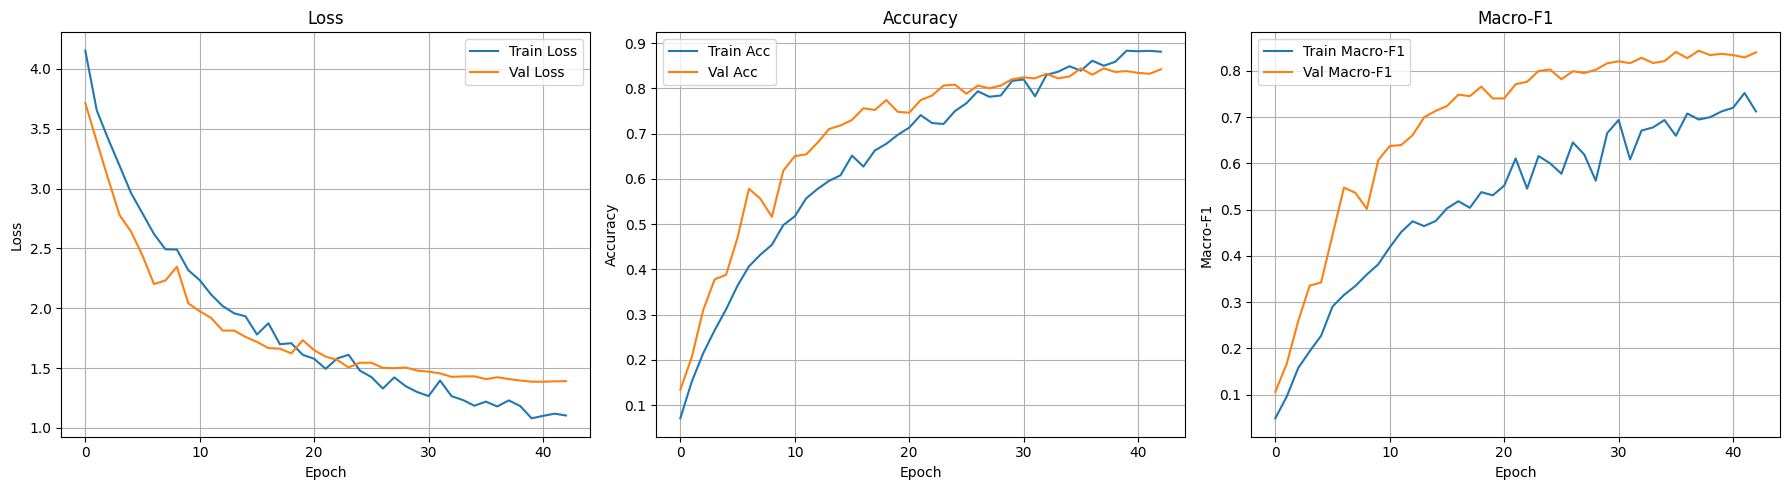

In [18]:
plot_history(history)

In [19]:
test_ds, test_loader = build_test_loader(cfg, device)

test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader, device)

print("-" * 30)
print(f"Test Set Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Set Macro F1: {test_f1:.4f}")
print("-" * 30)

Test samples found: 500
Classes found: 100
------------------------------
Test Set Accuracy: 0.8640 (86.40%)
Test Set Macro F1: 0.8588
------------------------------


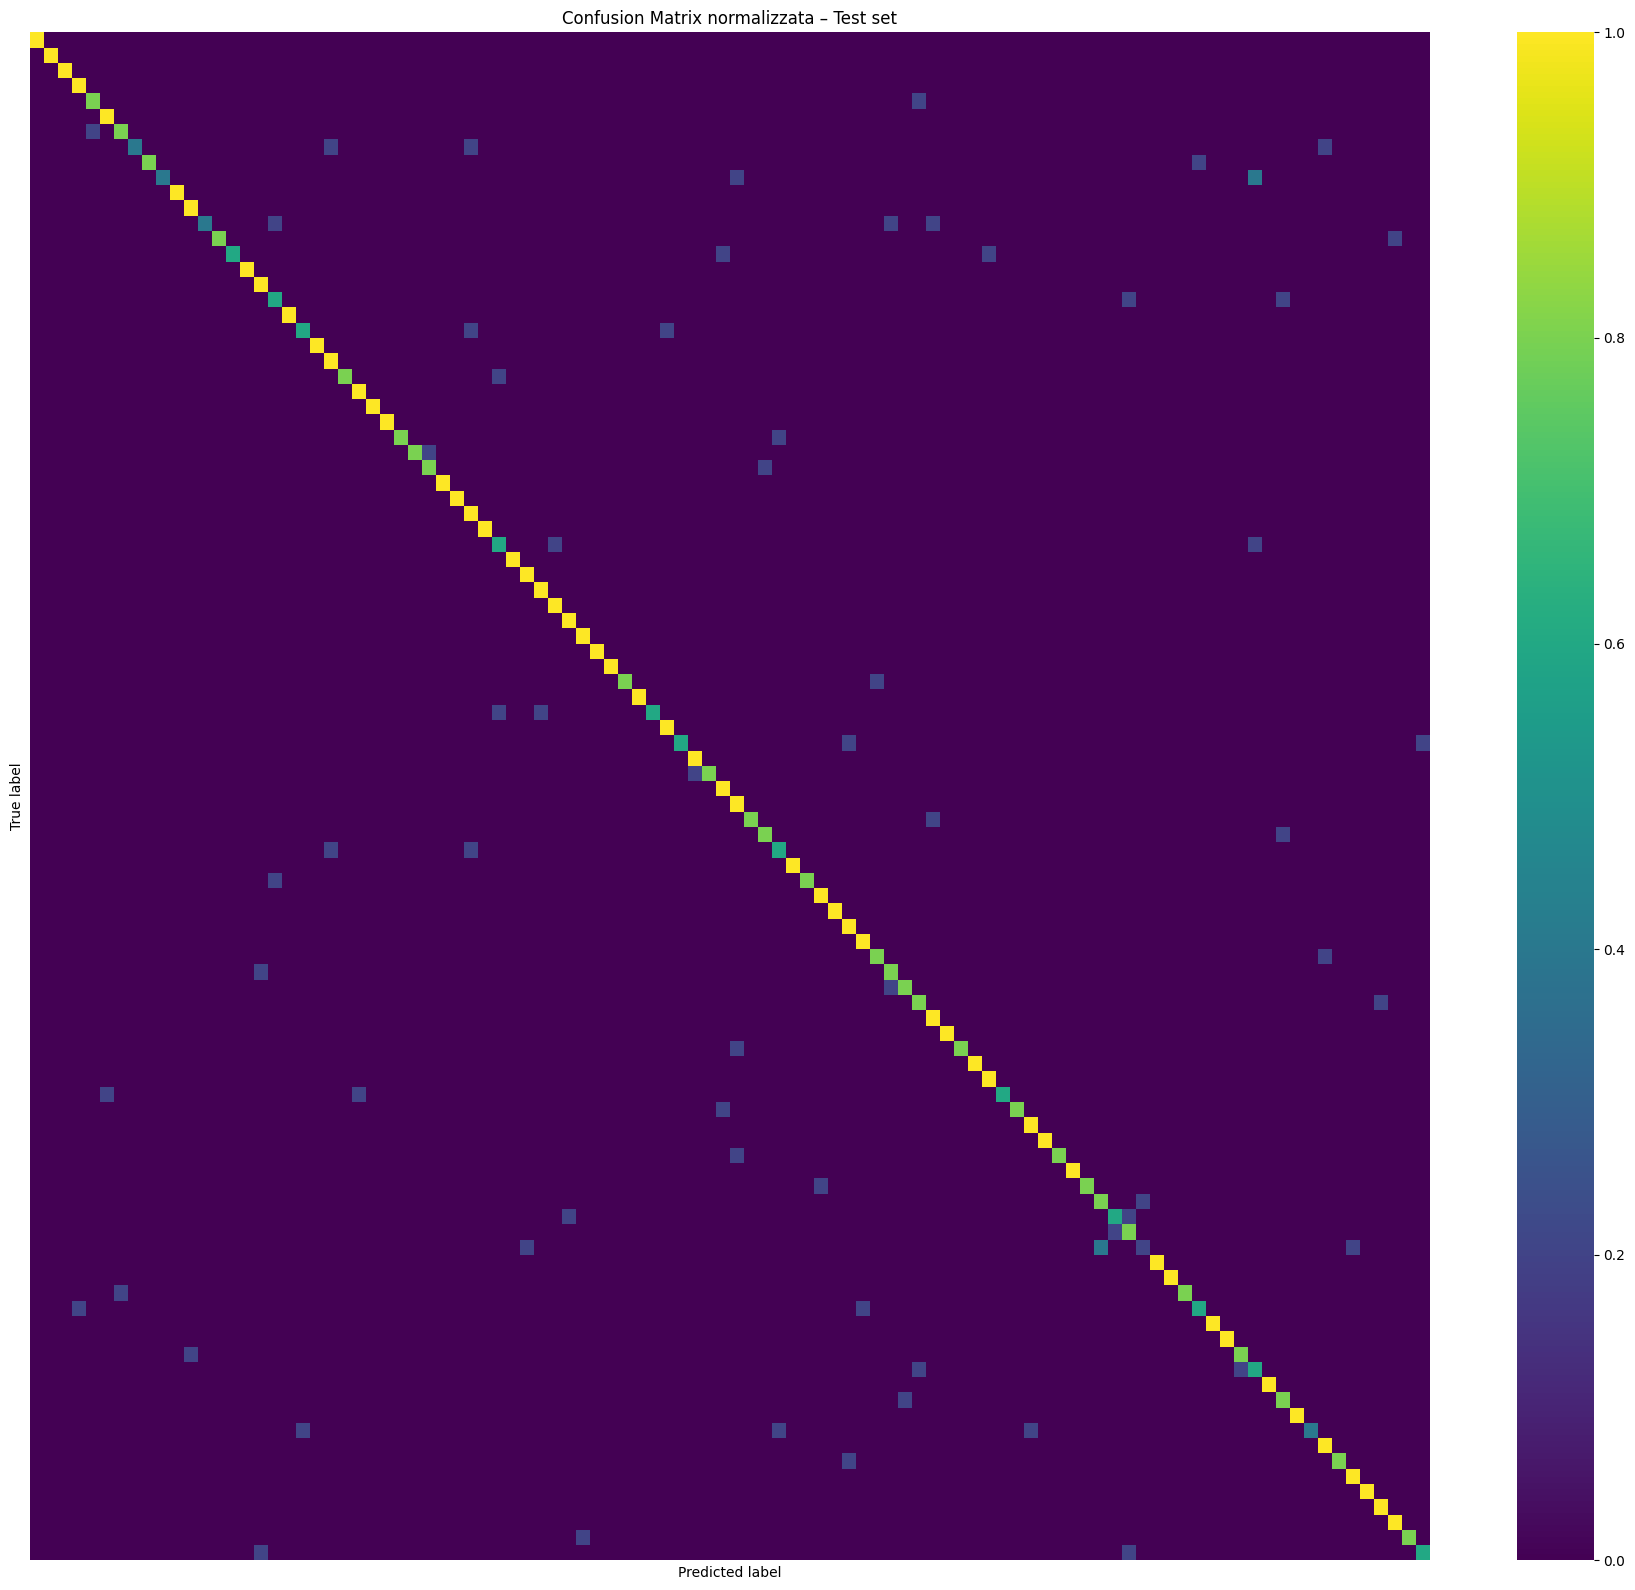

In [21]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, title="Confusion Matrix normalizzata – Test set")


In [22]:
print_top_confusions(cm, test_ds.classes, top_k=100)


Top 100 coppie più confuse:

baton twirling → tennis  | 2 errori
snow boarding → ski jumping  | 2 errori
axe throwing → pole vault  | 1 errori
barell racing → axe throwing  | 1 errori
baseball → cricket  | 1 errori
baseball → football  | 1 errori
baseball → uneven bars  | 1 errori
basketball → sumo wrestling  | 1 errori
baton twirling → javelin  | 1 errori
bmx → bungee jumping  | 1 errori
bmx → pole climbing  | 1 errori
bmx → polo  | 1 errori
bobsled → wheelchair basketball  | 1 errori
bowling → jai alai  | 1 errori
bowling → roller derby  | 1 errori
bungee jumping → skydiving  | 1 errori
bungee jumping → trapeze  | 1 errori
cheerleading → football  | 1 errori
cheerleading → hurdles  | 1 errori
croquet → frisbee  | 1 errori
field hockey → lacrosse  | 1 errori
figure skating men → figure skating pairs  | 1 errori
figure skating pairs → judo  | 1 errori
frisbee → hammer throw  | 1 errori
frisbee → tennis  | 1 errori
horse jumping → parallel bar  | 1 errori
horseshoe pitching → frisbee  